## Super Resolution GAN training
### Based on the initial SRGAN paper: https://arxiv.org/abs/1609.04802 

In [15]:
import torch
from torch import nn
from torch import optim
from PIL import Image
import albumentations as A
from albumentations.pytorch import ToTensorV2
import os
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision.models import vgg19
from torchvision.utils import save_image
from tqdm import tqdm
import matplotlib.pyplot as plt


LOAD_DISC = True
LOAD_GEN = True

SAVE_MODEL = True

DISC_TRAIN = True

WORK_PATH = "c:/SRGAN/"
IMAGE_PATH = "HI_RES/"
CHECKPOINT_GEN = "gen_srgan.pth"
CHECKPOINT_DISC = "disc_srgan.pth"
TEST_IMAGES = "test_images/"
RESULT_IMAGES = "result_images/"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-5
NUM_EPOCHS = 2000 
BATCH_SIZE = 16
NUM_WORKERS = 0
HIGH_RES = 96
LOW_RES = HIGH_RES // 4
DISK_CONV = HIGH_RES // (2**4)
IMG_CHANNELS = 3
PLOT_FFREQUENCY = 50

In [ ]:
# Download low-res validation dataset
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_valid_LR_bicubic_X4.zip
#!unzip DIV2K_valid_LR_bicubic_X4.zip

In [ ]:
# Download hi-res training dataset
#!wget http://data.vision.ee.ethz.ch/cvl/DIV2K/DIV2K_train_HR.zip
#!unzip DIV2K_train_HR.zip 

In [16]:
# High-res images transformations
highres_transform = A.Compose(
    [
        A.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
        ToTensorV2(),
    ]
)

# Low-res images transformations
lowres_transform = A.Compose(
    [
        A.Resize(width=LOW_RES, height=LOW_RES, interpolation=Image.BICUBIC),
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

# High-res and lowres initial images transformations
both_transforms = A.Compose(
    [
        A.RandomCrop(width=HIGH_RES, height=HIGH_RES),
        A.HorizontalFlip(p=0.3),
        A.VerticalFlip(p=0.3),
        A.RandomRotate90(p=0.3),
    ]
)

# Test images transformations
test_transform = A.Compose(
    [
        A.Normalize(mean=[0, 0, 0], std=[1, 1, 1]),
        ToTensorV2(),
    ]
)

In [17]:
# Simple class for loading images from folder
class MyImageFolder(Dataset):
    def __init__(self, root_dir):
        super(MyImageFolder, self).__init__()
        self.root_dir = root_dir
        self.files = os.listdir(root_dir)    

    def __len__(self):
        return len(self.files)

    def __getitem__(self, index):
        img_file = self.files[index]
        image = np.array(Image.open(os.path.join(self.root_dir, img_file)))
        image = both_transforms(image=image)["image"]
        high_res = highres_transform(image=image)["image"]
        low_res = lowres_transform(image=image)["image"]
        return low_res, high_res


def test1():
    dataset = MyImageFolder(root_dir=os.path.join(WORK_PATH, IMAGE_PATH))
    loader = DataLoader(dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)

    low_res, high_res = next( iter(loader))
    print(low_res.shape)
    print(high_res.shape)
    print(len(dataset))

test1()


torch.Size([16, 3, 24, 24])
torch.Size([16, 3, 96, 96])
800


In [19]:
# Residual block
class Residual_Block(nn.Module):
    def __init__(self, num_channels):
        super(Residual_Block, self).__init__()

        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels),
            nn.PReLU(num_parameters=num_channels),
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels)
        )

    def forward(self, x):
        out = self.conv(x)
        out = torch.add(out, x)
        return out

In [20]:
# Convolution block
class Conv_Block(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(Conv_Block, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, **kwargs),
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(0.2, inplace=True)
        )

    def forward(self, x):
        out = self.conv(x)
        return out

In [21]:
# Generator model
class Generator(nn.Module):
    def __init__(self, in_channels=3, num_channels=64, num_blocks=16):
        super(Generator, self).__init__()

        self.conv_initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=num_channels, kernel_size=9, stride=1, padding=4, bias=True),
            nn.PReLU(num_parameters=num_channels)
        )

        self.residuals_sequence = nn.Sequential(*[Residual_Block(num_channels) for _ in range(num_blocks)])
        
        self.conv_midddle = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels, kernel_size=3, stride=1, padding=1, bias=False),
            nn.BatchNorm2d(num_channels)
        )
        
        self.upsample = nn.Sequential(
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PixelShuffle(2),
            nn.PReLU(num_parameters=num_channels),
            nn.Conv2d(in_channels=num_channels, out_channels=num_channels * 4, kernel_size=3, stride=1, padding=1, bias=True),
            nn.PixelShuffle(2),
            nn.PReLU(num_parameters=num_channels)
        )

        self.conv_final = nn.Conv2d(num_channels, in_channels, kernel_size=9, stride=1, padding=4, bias=True)


    def forward(self, x):
        initial = self.conv_initial(x)
        out = self.residuals_sequence(initial)
        out = self.conv_midddle(out)
        out = torch.add(out, initial)
        out = self.upsample(out)
        out = self.conv_final(out)
        out = torch.tanh(out)
        return out

In [22]:
# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, in_channels=3):
        super().__init__()

        # (3) x 96 x 96
        self.conv_initial = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.LeakyReLU(0.2, inplace=True)
        )
        # (64) x 96 x 96

        self.conv_sequence = nn.Sequential(
            Conv_Block(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding=1, bias=False), # (64) x 48 x 48     
            Conv_Block(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=False), # (128) x 48 x 48           
            Conv_Block(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1, bias=False), # (128) x 24 x 24
            Conv_Block(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=False), # (256) x 24 x 24
            Conv_Block(in_channels=256, out_channels=256, kernel_size=3, stride=2, padding=1, bias=False), # (256) x 12 x 12
            Conv_Block(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=False),  # (512) x 12 x 12          
            Conv_Block(in_channels=512, out_channels=512, kernel_size=3, stride=2, padding=1, bias=False),  # (512) x 6 x 6          
        )

        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d((6, 6)),
            nn.Flatten(),
            nn.Linear(512*DISK_CONV*DISK_CONV, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 1),
        )

    def forward(self, x):
        out = self.conv_initial(x)
        out = self.conv_sequence(out)
        out = self.classifier(out)
        return out

In [23]:
def test():
    low_resolution = 24  # 96x96 -> 24x24
    x = torch.randn((5, 3, low_resolution, low_resolution))
    gen = Generator()
    gen_out = gen(x)
    disc = Discriminator()
    disc_out = disc(gen_out)
    print(gen_out.shape)
    print(disc_out.shape)

test()

torch.Size([5, 3, 96, 96])
torch.Size([5, 1])


In [24]:
# VGG19-based loss module
class VGGLoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.vgg = vgg19(pretrained=True).features[:36].eval().to(DEVICE)
        self.loss = nn.MSELoss()

        for param in self.vgg.parameters():
            param.requires_grad = False

    def forward(self, input, target):
        vgg_input_features = self.vgg(input)
        vgg_target_features = self.vgg(target)
        return self.loss(vgg_input_features, vgg_target_features)

In [25]:
# Saving model checkpoint
def save_checkpoint(model, optimizer, filename="my_checkpoint.pth"):
    filename = os.path.join(WORK_PATH, filename)
    print("=> Saving checkpoint to " + filename)
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer": optimizer.state_dict(),
    }
    torch.save(checkpoint, filename)

# Loading model checkpoint
def load_checkpoint(filename, model, optimizer, lr):
    filename = os.path.join(WORK_PATH, filename)
    print("=> Loading checkpoint from " + filename)
    checkpoint = torch.load(filename, map_location=DEVICE)
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr

# Generating a set of hi-res images from low-res validation images
def plot_examples(gen):
    files_folder = os.path.join(WORK_PATH, TEST_IMAGES)
    files = os.listdir(files_folder)

    gen.eval()
    for file in files:
        image = Image.open(os.path.join(files_folder, file))
        with torch.no_grad():
            upscaled_img = gen(
                test_transform(image=np.asarray(image))["image"]
                .unsqueeze(0)
                .to(DEVICE)
            )
        save_image(upscaled_img * 0.5 + 0.5, os.path.join(os.path.join(WORK_PATH, RESULT_IMAGES), file))
    gen.train()

=> Loading checkpoint from c:/SRGAN/gen_srgan.pth
=> Loading checkpoint from c:/SRGAN/disc_srgan.pth


Epoch [50/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it, fake_score=0.0997, loss_d=0.304, loss_g=0.0396, real_score=0.939] 


Plotting samples for epoch 50


Epoch [100/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0241, loss_d=0.234, loss_g=0.033, real_score=0.971]  


Plotting samples for epoch 100


Epoch [150/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.147, loss_d=0.378, loss_g=0.0248, real_score=0.968]  


Plotting samples for epoch 150


Epoch [200/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.014, loss_d=0.199, loss_g=0.0395, real_score=0.963]  


Plotting samples for epoch 200


Epoch [250/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it, fake_score=0.0745, loss_d=0.29, loss_g=0.0417, real_score=0.969]  


Plotting samples for epoch 250


Epoch [300/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0429, loss_d=0.366, loss_g=0.0317, real_score=0.777] 


Plotting samples for epoch 300


Epoch [350/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it, fake_score=0.022, loss_d=0.217, loss_g=0.0337, real_score=0.941]  


Plotting samples for epoch 350


Epoch [400/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0429, loss_d=0.241, loss_g=0.0213, real_score=0.971] 


Plotting samples for epoch 400


Epoch [450/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00522, loss_d=1.07, loss_g=0.0209, real_score=0.365] 


Plotting samples for epoch 450


Epoch [500/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.249, loss_d=0.482, loss_g=0.0313, real_score=0.96]   


Plotting samples for epoch 500


Epoch [550/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it, fake_score=0.00451, loss_d=0.228, loss_g=0.0449, real_score=0.943]


Plotting samples for epoch 550


Epoch [600/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00702, loss_d=0.266, loss_g=0.02, real_score=0.852]  


Plotting samples for epoch 600


Epoch [650/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.06s/it, fake_score=0.1, loss_d=0.374, loss_g=0.0195, real_score=0.981]    


Plotting samples for epoch 650


Epoch [700/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0524, loss_d=0.287, loss_g=0.0332, real_score=0.955] 


Plotting samples for epoch 700


Epoch [750/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0149, loss_d=0.241, loss_g=0.0286, real_score=0.93]  


Plotting samples for epoch 750


Epoch [800/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0263, loss_d=0.528, loss_g=0.0277, real_score=0.645] 


Plotting samples for epoch 800


Epoch [850/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00926, loss_d=0.199, loss_g=0.045, real_score=0.953] 


Plotting samples for epoch 850


Epoch [900/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0747, loss_d=0.319, loss_g=0.0204, real_score=0.958] 


Plotting samples for epoch 900


Epoch [950/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.117, loss_d=0.597, loss_g=0.023, real_score=0.652]   


Plotting samples for epoch 950


Epoch [1000/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0617, loss_d=0.277, loss_g=0.0307, real_score=0.909] 


Plotting samples for epoch 1000


Epoch [1050/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00812, loss_d=0.195, loss_g=0.028, real_score=0.955] 


Plotting samples for epoch 1050


Epoch [1100/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.645, loss_d=1.28, loss_g=0.0435, real_score=0.95]     


Plotting samples for epoch 1100


Epoch [1150/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.144, loss_d=0.316, loss_g=0.0224, real_score=0.945]  


Plotting samples for epoch 1150


Epoch [1200/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00719, loss_d=0.909, loss_g=0.0215, real_score=0.421]


Plotting samples for epoch 1200


Epoch [1250/2000]: 100%|██████████| 50/50 [00:51<00:00,  1.04s/it, fake_score=0.00972, loss_d=0.267, loss_g=0.0204, real_score=0.859]


Plotting samples for epoch 1250


Epoch [1300/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0109, loss_d=0.19, loss_g=0.0323, real_score=0.972]  


Plotting samples for epoch 1300


Epoch [1350/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00284, loss_d=0.225, loss_g=0.0312, real_score=0.953]


Plotting samples for epoch 1350


Epoch [1400/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00164, loss_d=2.19, loss_g=0.0276, real_score=0.13]  


Plotting samples for epoch 1400


Epoch [1450/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0526, loss_d=0.228, loss_g=0.0256, real_score=0.951] 


Plotting samples for epoch 1450


Epoch [1500/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it, fake_score=0.0606, loss_d=0.285, loss_g=0.0314, real_score=0.943] 


Plotting samples for epoch 1500


Epoch [1550/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0159, loss_d=0.19, loss_g=0.0352, real_score=0.937]   


Plotting samples for epoch 1550


Epoch [1600/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it, fake_score=0.00168, loss_d=1.08, loss_g=0.0249, real_score=0.353]  


Plotting samples for epoch 1600


Epoch [1650/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0596, loss_d=0.246, loss_g=0.0343, real_score=0.956] 


Plotting samples for epoch 1650


Epoch [1700/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.00705, loss_d=0.214, loss_g=0.0269, real_score=0.939]


Plotting samples for epoch 1700


Epoch [1750/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.04s/it, fake_score=0.233, loss_d=0.475, loss_g=0.0189, real_score=0.969]  


Plotting samples for epoch 1750


Epoch [1800/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0779, loss_d=0.299, loss_g=0.0293, real_score=0.945] 


Plotting samples for epoch 1800


Epoch [1850/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.505, loss_d=0.966, loss_g=0.0503, real_score=0.956]  


Plotting samples for epoch 1850


Epoch [1900/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0033, loss_d=0.564, loss_g=0.0362, real_score=0.593] 


Plotting samples for epoch 1900


Epoch [1950/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.183, loss_d=0.407, loss_g=0.0329, real_score=0.969]  


Plotting samples for epoch 1950


Epoch [2000/2000]: 100%|██████████| 50/50 [00:52<00:00,  1.05s/it, fake_score=0.0727, loss_d=0.482, loss_g=0.0148, real_score=0.704] 


Plotting samples for epoch 2000
=> Saving checkpoint to c:/SRGAN/gen_srgan.pth
=> Saving checkpoint to c:/SRGAN/disc_srgan.pth


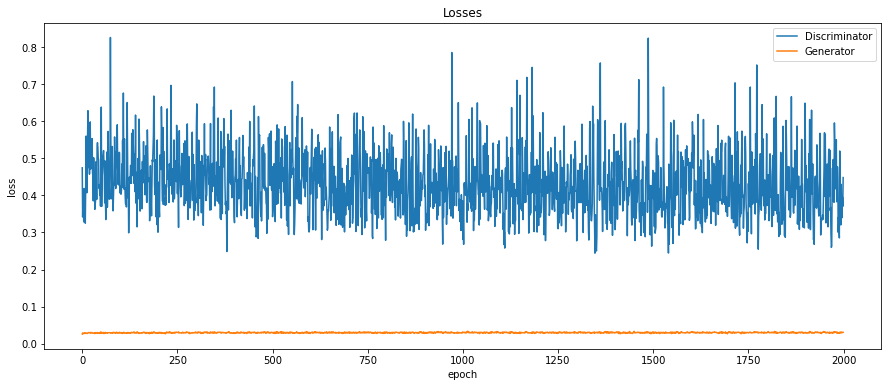

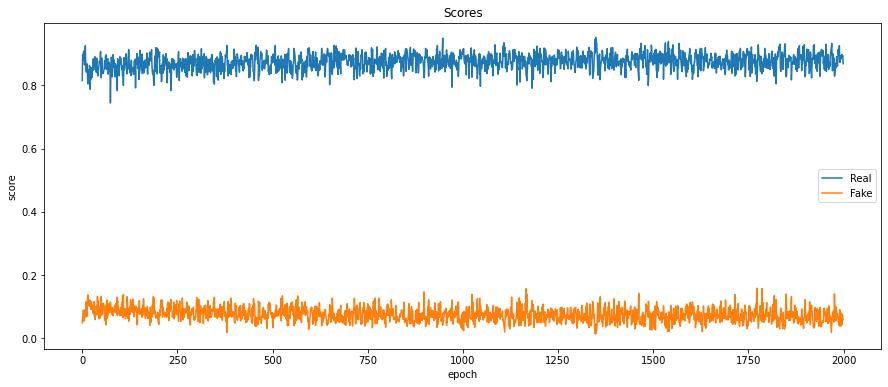

In [26]:
torch.backends.cudnn.benchmark = True

# Training procedure
def train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, epoch):
    loop = tqdm(loader, leave=True)
    loop.set_description(f"Epoch [{epoch+1}/{NUM_EPOCHS}]")

    loss_d_per_epoch = [] 
    loss_g_per_epoch = []
    real_score_per_epoch = []
    fake_score_per_epoch = []

    for _, (low_res, high_res) in enumerate(loop):
        high_res = high_res.to(DEVICE)
        low_res = low_res.to(DEVICE)
        
        fake = gen(low_res)
        l2_loss = mse(fake, high_res)

        # Train Discriminator: max log(D(x)) + log(1 - D(G(z)))
        if DISC_TRAIN:
            disc_real = disc(high_res)
            cur_real_score = torch.mean(torch.sigmoid(disc_real)).item() #
            
            disc_fake = disc(fake.detach())
            cur_fake_score = torch.mean(torch.sigmoid(disc_fake)).item() #
        
            disc_loss_real = bce(disc_real, torch.ones_like(disc_real) - 0.1 * torch.rand_like(disc_real)) # Label smoothing
            disc_loss_fake = bce(disc_fake, torch.zeros_like(disc_fake)) 
            loss_disc = disc_loss_fake + disc_loss_real

            opt_disc.zero_grad()
            loss_disc.backward()
            opt_disc.step()

            disc_fake = disc(fake)

            # Define different losses for Generattor
            adversarial_loss = 1e-3 * bce(disc_fake, torch.ones_like(disc_fake))
            loss_for_vgg = (1.0/12.75) * vgg_loss(fake, high_res)
            gen_loss = l2_loss + loss_for_vgg + adversarial_loss
        else:
            gen_loss = l2_loss
            # Define zero losses and scores if not training the Discriminator
            # just for uniform output representation
            cur_real_score = 0
            cur_fake_score = 0
            loss_disc = torch.zeros(1)

        # Train Generator: min log(1 - D(G(z))) <-> max log(D(G(z))

        opt_gen.zero_grad()
        gen_loss.backward()
        opt_gen.step()

        loss_d_per_epoch.append(loss_disc.item()) 
        loss_g_per_epoch.append(gen_loss.item()) 
        real_score_per_epoch.append(cur_real_score) 
        fake_score_per_epoch.append(cur_fake_score) 

        loop.set_postfix(loss_g=gen_loss.item(), loss_d=loss_disc.item(), real_score=cur_real_score, fake_score=cur_fake_score)

    # Record losses & scores
    losses_g_e = np.mean(loss_g_per_epoch)
    losses_d_e = np.mean(loss_d_per_epoch)
    real_scores_e = np.mean(real_score_per_epoch)
    fake_scores_e = np.mean(fake_score_per_epoch)

    return losses_g_e, losses_d_e, real_scores_e, fake_scores_e
   

def main():
    # Initialize dataset
    dataset = MyImageFolder(root_dir=os.path.join(WORK_PATH, IMAGE_PATH))
    loader = DataLoader(
        dataset,
        batch_size=BATCH_SIZE,
        shuffle=True,
        pin_memory=True,
        num_workers=NUM_WORKERS,
    )
    # Define models and losses
    gen = Generator(in_channels=3).to(DEVICE)
    disc = Discriminator(in_channels=3).to(DEVICE)
    opt_gen = optim.Adam(gen.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    opt_disc = optim.Adam(disc.parameters(), lr=LEARNING_RATE, betas=(0.9, 0.999))
    mse = nn.MSELoss()
    bce = nn.BCEWithLogitsLoss()
    vgg_loss = VGGLoss()

    if LOAD_GEN:
        load_checkpoint(CHECKPOINT_GEN, gen, opt_gen, LEARNING_RATE)
    if LOAD_DISC:
        load_checkpoint(CHECKPOINT_DISC, disc, opt_disc, LEARNING_RATE)

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []
    
    for epoch in range(NUM_EPOCHS):
        losses_g_e, losses_d_e, real_scores_e, fake_scores_e = train_fn(loader, disc, gen, opt_gen, opt_disc, mse, bce, vgg_loss, epoch)
        
        losses_g.append(losses_g_e)
        losses_d.append(losses_d_e)
        real_scores.append(real_scores_e)
        fake_scores.append(fake_scores_e)
        
        if (epoch+1) % PLOT_FFREQUENCY == 0:
            print(f"Plotting samples for epoch {epoch+1}" )
            plot_examples(gen)
    
    if SAVE_MODEL:
        save_checkpoint(gen, opt_gen, filename=CHECKPOINT_GEN)
        save_checkpoint(disc, opt_disc, filename=CHECKPOINT_DISC)

    # Show Losses
    plt.figure(figsize=(15, 6))
    plt.plot(losses_d, '-')
    plt.plot(losses_g, '-')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Discriminator', 'Generator'])
    plt.title('Losses')
    plt.show()

    if DISC_TRAIN:
        # Show Scores
        plt.figure(figsize=(15, 6))
        plt.plot(real_scores, '-')
        plt.plot(fake_scores, '-')
        plt.xlabel('epoch')
        plt.ylabel('score')
        plt.legend(['Real', 'Fake'])
        plt.title('Scores')
        plt.show()


main()

In [27]:
torch.cuda.empty_cache()

In [28]:
###############################